(unsupervised:hierarchical-clustering)=
# Hierarchical Clustering

Hierarchical clustering algorithms not only yield one clustering but a series of clusterings. There are two approaches for generating a series of clusters:
* *coarse to fine* or *divisive* (the first clustering consists of only one cluster (the whole training data set) and the last contains as many clusters as there are samples),
* *fine to coarse* or *agglomerative* (the first clustering contains as many clusters as samples and the last clustering has only one large cluster).

In the first case the next clustering results from splitting a cluster in the previous clustering by some rule. In the second case two clusters are selected by some rule and than joined to form only one cluster.
Both variants result in a nested sequence of clusters, usually (not always) with increasing intercluster dissimilarity from fine to coarse.

Hierarchical clustering methods do not imply canonical prediction routines (in contrast to $k$-means). They only assign labels to the training data. To add new data points to existing clusters $k$NN or some other supervised learning technique has to be used.

Related projects:
* [](projects:celadons)
  * [](projects:celadons:hierarchical)

## Dendrograms

The aim of hierarchical clustering is not only to find a good clustering, but to better understand structures in the data set. A *dendrogram* is a graphical representation of a sequence of nested clusterings. On the one hand, a dendrogram shows relations between clusters of different clusterings. On the other hand, it provides information about dissimilarity of clusters within one clustering.

A dendrogram is a binary (that is, two children per parent node) tree. Each node represents a subset (cluster) of the data set. The whole data set is the root node and there are as many leaves as there are samples in the data set. Each intermediate node represents the union of its two children. The height of a node in the tree is related to the value of a dissimilarity measure between clusters which lead to the split or join operation.

```{figure} dendrogram.svg
---
alt: dendrogram
---
A dendrogram and corresponding clusters.
```

Dendrograms can be used to determine the number of clusters in a data set. The wider the height gap between two nodes, the better the clustering (with respect to the chosen distance). Here 'better' means that the clustering corresponding to a wide gap is very stable with respect to the merging criterion, that is, contains no subclusters with low dissimilarity. See below for an example.

## Divisive Clustering

Divisive clustering is rarely used in practice, because good splitting stategies are computationally expensive. One possible approach is to find the cluster with highest intracluster dissimilarity and then use $k$-means with $k=2$ for splitting the cluster. Depending on the chosen dissimilarity measure dissimilarity values at subsequent splits may be nondecreasing. Thus, height of nodes in the dendrogram cannot encode dissimilarity.

## Agglomerative Clustering

For agglomerative clustering we have to choose a point-to-point distance $d$ (Euclidean distance, for instance) and a distance $D$ between two disjoint sets. Next to some relatively uncommon variants there are three major notions for distances between disjoint sets:
* minimum distance of points (*single linkage clustering*):
  \begin{equation*}
  D(C,\tilde{C}):=\min_{x\in C,\tilde{x}\in\tilde{C}}d(x,\tilde{x}),
  \end{equation*}
* maximum distance of points (*complete linkage clustering*):
  \begin{equation*}
  D(C,\tilde{C}):=\max_{x\in C,\tilde{x}\in\tilde{C}}d(x,\tilde{x}),
  \end{equation*}
* average distance of points (*average linkage clustering*):
  \begin{equation*}
  D(C,\tilde{C}):=\frac{1}{|C|\,|\tilde{C}|}\,\sum_{x\in C}\sum_{\tilde{x}\in\tilde{C}}d(x,\tilde{x}).
  \end{equation*}

Starting with the finest clustering the following steps are repeated until there is only one large cluster containing the whole data set:
* Calculate the distance $D$ for each pair of clusters.
* Join the two clusters with smallest distance.

Clustering results for different distance measures may differ significantly.
Single linkage clustering suffers from *chaining*. That is, several (for human eyes) clearly separated clusters are joined into one because they touch at one point. An advantage of single linkage clustering is that it finds clusters of arbitrary shape and does not prefer convex clusters.
Complete linkage prefers compact sphere shaped clusters. Average linkage is a compromise between both extremes.
Have a look at the plots of the [linkage example in Scikit-Learn's documentaion](https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html).

## Hierarchical Clustering with Scikit-Learn

Scikit-Learn only supports agglomerative clustering via [`AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) class. We either have to provide the number of clusters `n_clusters` or the distance `distance_threshold` at which to cut the dendrogram.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster as cluster

rng = np.random.default_rng(0)

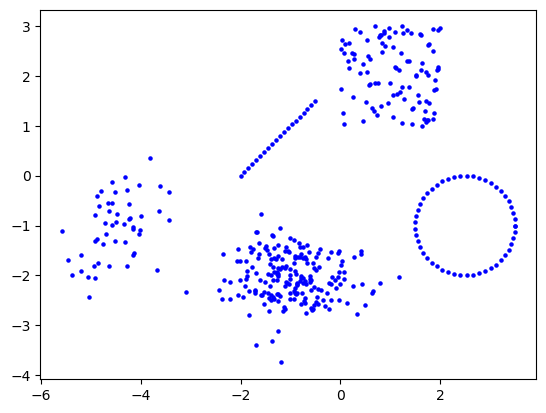

In [2]:
# 5 clusters in 2 dimensions

n1, n2, n3, n4, n5 = 100, 200, 20, 50, 50
n = n1 + n2 + n3 + n4 + n5

X1 = rng.uniform((0, 1), (2, 3), (n1, 2))
X2 = rng.multivariate_normal((-1, -2), ((0.5, 0), (0, 0.2)), n2)
X3 = np.linspace(-1, 0.5, n3).reshape(-1, 1) * np.ones((1, 2)) + np.array([[-1, 1]])
X4 = rng.multivariate_normal((-4.5, -1), ((0.2, 0.1), (0.1, 0.4)), n4)
phi = np.linspace(0, 2 * np.pi, n5).reshape(-1, 1)
X5 = np.array([[2.5, -1]]) + np.concatenate((np.cos(phi), np.sin(phi)), axis=1)

X = np.concatenate((X1, X2, X3, X4, X5))

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=5, c='b')
ax.axis('equal')
plt.show()

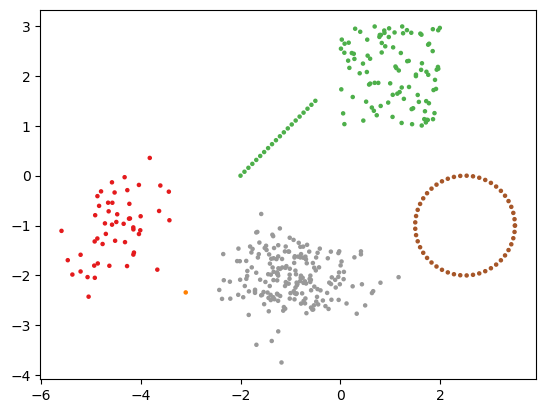

In [3]:
ac = cluster.AgglomerativeClustering(5, linkage='single')
ac.fit(X)

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=5, c=ac.labels_, cmap='Set1')
ax.axis('equal')
plt.show()

Neither Scikit-Learn, nor Matplotlib, nor Seaborn support plotting dendrograms directly. Only [SciPy](https://docs.scipy.org/doc/scipy/index.html) has a [`dendrogram`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html) function for plotting. SciPy also has the [`linkage`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) function for agglomerative clustering. But we would like to use Scikit-Learn for clustering although SciPy shall plot the dendrogram. Thus, we have to adapt Scikit-Learn's output to the needs of SciPy.

In [4]:
import scipy.cluster.hierarchy as scipy_ch

In [5]:
def plot_dendrogram(ac, ax, max_nodes=10, color_threshold=0.5):
    
    n = ac.labels_.shape[0]    # number of samples
    
    data = np.empty((n - 1, 4))
    data[:, 0:2] = ac.children_
    data[:, 2] = ac.distances_

    # get number of samples per node
    for i in range(0, n - 1):    # visit each node
        c = 0

        # add samples from left child
        if ac.children_[i, 0] < n:    # child is leaf
            c = c + 1
        else:
            c = c + data[ac.children_[i, 0] - n, 3]

        # add samples from right child
        if ac.children_[i, 1] < n:    # child is leaf
            c = c + 1
        else:
            c = c + data[ac.children_[i, 1] - n, 3]
        data[i, 3] = c
    
    scipy_ch.dendrogram(data, ax=ax, truncate_mode='lastp', p=max_nodes, color_threshold=color_threshold)

Note that the `n_clusters` parameter of `AgglomerativeClustering` does not matter, because we are interested in the dendrogram, not in a particular clustering.

In [6]:
ac = cluster.AgglomerativeClustering(linkage='average', compute_distances=True)
ac.fit(X)

fig, ax = plt.subplots(figsize=(12, 8))
plot_dendrogram(ac, ax, 50, 2.5)
plt.show()

From the dendrogram we see that the number of clusters in the data is 2, 4 or 5.

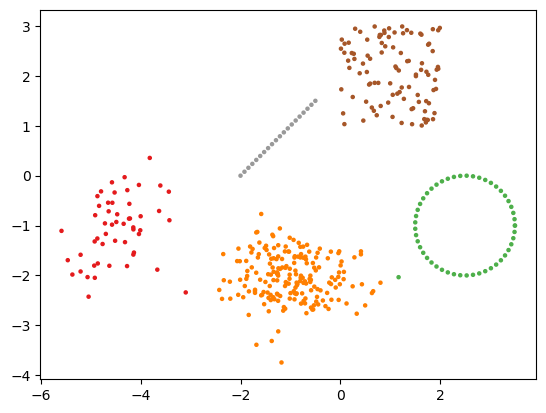

In [7]:
ac = cluster.AgglomerativeClustering(n_clusters=5, linkage='average')
ac.fit(X)

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=5, c=ac.labels_, cmap='Set1')
ax.axis('equal')
plt.show()

If we only are interested in the number of clusters we may plot the number of clusters versus the distance threshold and look for wide vertical gaps.

In [8]:
ac = cluster.AgglomerativeClustering(linkage='average', compute_distances=True)
ac.fit(X)

fig, ax = plt.subplots()

dists = ac.distances_
for i in range(dists.size - 100, dists.size):
    ax.plot([0, dists.size], [dists[i], dists[i]], '-b', linewidth=1)
ax.plot(range(dists.size + 1, 1, -1), dists, 'or', markersize=3)

ax.set_xlim(0, 30)
ax.set_xlabel('clusters')
ax.set_ylabel('distance threshold')
ax.grid(axis='x')

plt.show()